# 0.Import modules

In [54]:
import sys
import os
from pathlib import Path

import gc
import warnings

from datetime import datetime
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as se
import scipy.stats as stats
from tqdm import tqdm

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [3]:

# Set view options
se.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

%matplotlib inline

#   1.Business Understanding

In Kaggle's GoDaddy Microbusiness Density Forecasting competition, we are given 3135 time series of length 39. These time series are 39 month observations from 3135 unique USA counties between the months of August 2019 thru October 2022 inclusive. We are asked to predict microbusiness density for the next 8 months which are November 2022 thru June 2023 inclusive. Microbusiness density is the number of microbusinesses per 100 adults in specific county. We are asked to make 25080 predictions = 3135 * 8 and the public LB is the evaluation of 3135 predictions for the most recent month using SMAPE metric. The private LB is the evaluation of predictions after current month.


# 2.Load data

1. train.csv - the training set

    1.1 row_id - An ID code for the row.

    1.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    1.3 county_name - The written name of the county.

    1.4 state_name - The name of the state.

    1.5 first_day_of_month - The date of the first day of the month.

    1.6 microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
    
    1.7 active - The raw count of microbusinesses in the county. Not provided for the test set.

2. revealed_test.csv - the new part of train set. The same scheme as train.csv

3. census_starter.csv Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

    3.1 pct_bb_[year] - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.

    3.2 cfips - The CFIPS code.

    3.3 pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.

    3.4 pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.

    3.5 pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
    3.6 median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

4. test.csv Metadata for the submission rows. This file will remain unchanged throughout the competition.

    4.1 row_id - An ID code for the row.

    4.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    4.3 first_day_of_month - The date of the first day of the month.

5. sample_submission.csv A valid sample submission. This file will remain unchanged throughout the competition.

    5.1 row_id - An ID code for the row.
    
    5.2 microbusiness_density - The target variable.

In [4]:
#Paths
DATA_PATH = Path("../data")
DATA_PROCESSED_PATH = DATA_PATH / "processed"

In [5]:
train = pd.read_csv(DATA_PATH / "raw/train.csv")
train_revealed = pd.read_csv(DATA_PATH / "raw/revealed_test.csv")

submission_template = pd.read_csv(DATA_PATH / "raw/test.csv")
census = pd.read_csv(DATA_PATH / "raw/census_starter.csv")
submission_example = pd.read_csv(DATA_PATH / "raw/sample_submission.csv")

train = pd.concat([train, train_revealed])

train['ds'] = pd.to_datetime(train['first_day_of_month'])
train['year'] = train['ds'].dt.year
train['month'] = train['ds'].dt.month

# 3 Model

In [184]:
# A bunch of useful functions
def fix_new_population_in_january(submission):
    COLS = ['GEO_ID','NAME','S0101_C01_026E']
    df2020 = pd.read_csv(DATA_PATH / 'external/census/ACSST5Y2020.S0101-Data.csv',usecols=COLS)
    df2020 = df2020.iloc[1:]
    df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')
    
    df2021 = pd.read_csv(DATA_PATH / 'external/census/ACSST5Y2021.S0101-Data.csv',usecols=COLS)
    df2021 = df2021.iloc[1:]
    df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
    df2021.head()
    
    df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
    adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

    df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
    adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()
    
    submission['adult2020'] = submission.cfips.map(adult2020)
    submission['adult2021'] = submission.cfips.map(adult2021)
    
    submission['microbusiness_density'] = submission['microbusiness_density'] * submission['adult2020'] / submission['adult2021']

In [7]:
train.head()

row_id  cfips          county    state first_day_of_month  \
0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active         ds  year  month  
0               3.007682    1249 2019-08-01  2019      8  
1               2.884870    1198 2019-09-01  2019      9  
2               3.055843    1269 2019-10-01  2019     10  
3               2.993233    1243 2019-11-01  2019     11  
4               2.993233    1243 2019-12-01  2019     12

In [126]:
cfips_list = train['cfips'].unique()

In [56]:
prediction_df = pd.DataFrame()

for cfip in tqdm(cfips_list):
    train_data = TimeSeriesDataFrame.from_data_frame(
    train[train.cfips == cfip],
    id_column="cfips",
    timestamp_column="ds",
    )

    predictor = TimeSeriesPredictor(
    prediction_length=5,
    path="autogluon-m4-hourly",
    target="microbusiness_density",
    eval_metric="sMAPE",
    )

    predictor.fit(
        train_data,
        presets="medium_quality",
        time_limit=600,
        verbosity=0,
    )

    predictions = predictor.predict(train_data)
    prediction_df = pd.concat([prediction_df, predictions])

  0%|          | 0/3135 [00:00<?, ?it/s]================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 5,
 'random_seed': None,
 'target': 'microbusiness_density',
 'time_limit': 600,
 'verbosity': 0}
Provided training data set with 41 rows, 1 items (item = single time series). Average time series length is 41.0.
Training artifacts will be saved to: /Users/Artem_Boltaev/Documents/EPAM Projects/4. Microbisuness_Density_Forecasting_Kaggle/source_code/microbisuness_density_forecasting_kaggle/notebooks/autogluon-m4-hourly
No path specified. Models will be saved in: "AutogluonModels/ag-20230306_004337/"
ETS with seasonal = add requires seasonal_period > 1 (received seasonal_period = 1). Disabling seasonality.
	invalid frequency
	invalid frequency
Provided co

In [62]:
prediction_df.head(10)

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
1001    2023-01-01  3.472230  3.393765  3.420700  3.440123  3.456718   
        2023-02-01  3.483538  3.376155  3.413018  3.439598  3.462310   
        2023-03-01  3.488269  3.358328  3.402934  3.435098  3.462581   
        2023-04-01  3.499541  3.350889  3.401918  3.438714  3.470154   
        2023-05-01  3.504307  3.338902  3.395682  3.436625  3.471609   
1003    2023-01-01  8.250630  8.045070  8.115635  8.166517  8.209994   
        2023-02-01  8.250630  7.959924  8.059717  8.131676  8.193161   
        2023-03-01  8.250630  7.894589  8.016811  8.104941  8.180245   
        2023-04-01  8.250630  7.839509  7.980639  8.082403  8.169357   
        2023-05-01  8.250630  7.790983  7.948770  8.062546  8.159764   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
1001    2023-01-01  3.472230  3.487742  3.504337  3.523759  3.550695  
        2023-02-01  3.483538  3.504766  3.527478  3.554058  3.590920  
        2023-03-01  3.488269  3.513956  3.541439  3.573603  3.618209  
        2023-04-01  3.499541  3.528928  3.560368  3.597164  3.648193  
        2023-05-01  3.504307  3.537006  3.571989  3.612932  3.669712  
1003    2023-01-01  8.250630  8.291267  8.334744  8.385626  8.456191  
        2023-02-01  8.250630  8.308100  8.369585  8.441543  8.541337  
        2023-03-01  8.250630  8.321015  8.396320  8.484450  8.606672  
        2023-04-01  8.250630  8.331904  8.418858  8.520622  8.661752  
        2023-05-01  8.250630  8.341497  8.438714  8.552490  8.710278

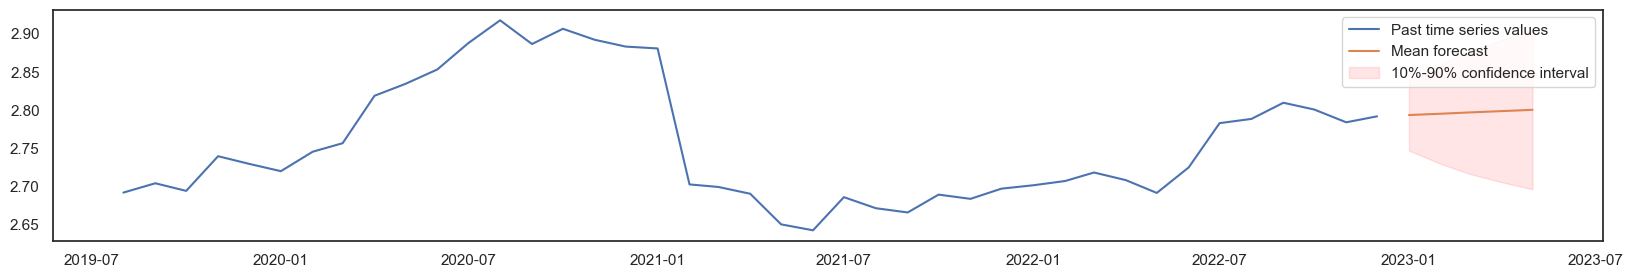

In [219]:
# Plot the predictions


plt.figure(figsize=(20, 3))

item_id = 1015
y_past = train[train.cfips == item_id]["microbusiness_density"].reset_index(drop=True)
x_past = train[train.cfips == item_id][["ds"]].reset_index(drop=True)

x_pred = prediction_df.loc[item_id].reset_index()[["timestamp"]]
y_pred = prediction_df.loc[item_id].reset_index()[["mean"]]

plt.plot(x_past, y_past, label="Past time series values")
plt.plot(x_pred, y_pred, label="Mean forecast")

plt.fill_between(
    prediction_df.loc[item_id].index,
    prediction_df.loc[item_id]["0.1"],
    prediction_df.loc[item_id]["0.9"],
    color="red",
    alpha=0.1,
    label=f"10%-90% confidence interval",
)
plt.legend()

# 4.Construct inference

inference from 2022-11-01 to 2023-05-01 <br>
2023-06-01 - not evaluate but need to predict

In [186]:
submission = submission_template.copy()
predictions = prediction_df.copy()

In [187]:
submission['first_day_of_month'] = pd.to_datetime(submission['first_day_of_month'])

In [188]:
predictions.reset_index(inplace=True)
predictions.rename(
    columns={"item_id": "cfips", "timestamp": "first_day_of_month"}, inplace=True
)
predictions.head()

cfips first_day_of_month      mean       0.1       0.2       0.3       0.4  \
0   1001         2023-01-01  3.472230  3.393765  3.420700  3.440123  3.456718   
1   1001         2023-02-01  3.483538  3.376155  3.413018  3.439598  3.462310   
2   1001         2023-03-01  3.488269  3.358328  3.402934  3.435098  3.462581   
3   1001         2023-04-01  3.499541  3.350889  3.401918  3.438714  3.470154   
4   1001         2023-05-01  3.504307  3.338902  3.395682  3.436625  3.471609   

        0.5       0.6       0.7       0.8       0.9  
0  3.472230  3.487742  3.504337  3.523759  3.550695  
1  3.483538  3.504766  3.527478  3.554058  3.590920  
2  3.488269  3.513956  3.541439  3.573603  3.618209  
3  3.499541  3.528928  3.560368  3.597164  3.648193  
4  3.504307  3.537006  3.571989  3.612932  3.669712

In [189]:
predictions['first_day_of_month'].max()

Timestamp('2023-05-01 00:00:00')

In [190]:
predictions['first_day_of_month'].min()

Timestamp('2023-01-01 00:00:00')

In [191]:
submission = submission.merge(
    predictions[["cfips", "first_day_of_month", "mean"]],
    on=["cfips", "first_day_of_month"],
    how="left",
)
submission.head()

row_id  cfips first_day_of_month  mean
0  1001_2022-11-01   1001         2022-11-01   NaN
1  1003_2022-11-01   1003         2022-11-01   NaN
2  1005_2022-11-01   1005         2022-11-01   NaN
3  1007_2022-11-01   1007         2022-11-01   NaN
4  1009_2022-11-01   1009         2022-11-01   NaN

In [192]:
submission.rename(columns={'mean': 'microbusiness_density'}, inplace=True)

In [193]:
submission_baseline = pd.read_csv('../notebooks/submission.csv')
submission_baseline.head()

row_id  microbusiness_density
0  1001_2022-11-01               3.332508
1  1001_2022-12-01               3.332508
2  1001_2023-01-01               3.332508
3  1001_2023-02-01               3.332508
4  1001_2023-03-01               3.332508

In [194]:
submission.fillna(value=submission_baseline, inplace=True)
submission.head()

row_id  cfips first_day_of_month  microbusiness_density
0  1001_2022-11-01   1001         2022-11-01               3.332508
1  1003_2022-11-01   1003         2022-11-01               3.332508
2  1005_2022-11-01   1005         2022-11-01               3.332508
3  1007_2022-11-01   1007         2022-11-01               3.332508
4  1009_2022-11-01   1009         2022-11-01               3.332508

In [195]:
fix_new_population_in_january(submission)
submission[['row_id', 'microbusiness_density']].to_csv(DATA_PATH / "processed/submission_autogluon_v1.csv", index=False)

In [141]:
predictions.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cfips               5 non-null      int64         
 1   first_day_of_month  5 non-null      datetime64[ns]
 2   mean                5 non-null      float64       
 3   0.1                 5 non-null      float64       
 4   0.2                 5 non-null      float64       
 5   0.3                 5 non-null      float64       
 6   0.4                 5 non-null      float64       
 7   0.5                 5 non-null      float64       
 8   0.6                 5 non-null      float64       
 9   0.7                 5 non-null      float64       
 10  0.8                 5 non-null      float64       
 11  0.9                 5 non-null      float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 608.0 bytes


In [197]:
submission[submission.cfips == 1001]

row_id  cfips first_day_of_month  microbusiness_density  \
0      1001_2022-11-01   1001         2022-11-01               3.186873   
3135   1001_2022-12-01   1001         2022-12-01               5.633293   
6270   1001_2023-01-01   1001         2023-01-01               3.320489   
9405   1001_2023-02-01   1001         2023-02-01               3.331302   
12540  1001_2023-03-01   1001         2023-03-01               3.335827   
15675  1001_2023-04-01   1001         2023-04-01               3.346606   
18810  1001_2023-05-01   1001         2023-05-01               3.351164   
21945  1001_2023-06-01   1001         2023-06-01               2.832551   

       adult2020  adult2021  
0          42496      44438  
3135       42496      44438  
6270       42496      44438  
9405       42496      44438  
12540      42496      44438  
15675      42496      44438  
18810      42496      44438  
21945      42496      44438

In [196]:

#pandas find rows wich contain in string '3434'
submission_baseline[submission_baseline['row_id'].str.contains('1001')]

row_id  microbusiness_density
0       1001_2022-11-01               3.332508
1       1001_2022-12-01               3.332508
2       1001_2023-01-01               3.332508
3       1001_2023-02-01               3.332508
4       1001_2023-03-01               3.332508
5       1001_2023-04-01               3.332508
6       1001_2023-05-01               3.332508
7       1001_2023-06-01               3.332508
2536   11001_2022-11-01              14.571106
2537   11001_2022-12-01              14.571106
2538   11001_2023-01-01              14.571106
2539   11001_2023-02-01              14.571106
2540   11001_2023-03-01              14.571106
2541   11001_2023-04-01              14.571106
2542   11001_2023-05-01              14.571106
2543   11001_2023-06-01              14.571106
7928   21001_2022-11-01               2.187104
7929   21001_2022-12-01               2.187104
7930   21001_2023-01-01               2.187104
7931   21001_2023-02-01               2.187104
7932   21001_2023-03-01               2.187104
7933   21001_2023-04-01               2.187104
7934   21001_2023-05-01               2.187104
7935   21001_2023-06-01               2.187104
13216  31001_2022-11-01               2.564485
13217  31001_2022-12-01               2.564485
13218  31001_2023-01-01               2.564485
13219  31001_2023-02-01               2.564485
13220  31001_2023-03-01               2.564485
13221  31001_2023-04-01               2.564485
13222  31001_2023-05-01               2.564485
13223  31001_2023-06-01               2.564485
17640  41001_2022-11-01               3.341941
17641  41001_2022-12-01               3.341941
17642  41001_2023-01-01               3.341941
17643  41001_2023-02-01               3.341941
17644  41001_2023-03-01               3.341941
17645  41001_2023-04-01               3.341941
17646  41001_2023-05-01               3.341941
17647  41001_2023-06-01               3.341941
22528  51001_2022-11-01               2.384780
22529  51001_2022-12-01               2.384780
22530  51001_2023-01-01               2.384780
22531  51001_2023-02-01               2.384780
22532  51001_2023-03-01               2.384780
22533  51001_2023-04-01               2.384780
22534  51001_2023-05-01               2.384780
22535  51001_2023-06-01               2.384780

In [181]:
submission.tail()

row_id  cfips first_day_of_month  microbusiness_density
25075  56037_2023-06-01  56037         2023-06-01               1.836698
25076  56039_2023-06-01  56039         2023-06-01               1.836698
25077  56041_2023-06-01  56041         2023-06-01               1.836698
25078  56043_2023-06-01  56043         2023-06-01               1.836698
25079  56045_2023-06-01  56045         2023-06-01               1.836698